In [1]:
import numpy as np
import pylab as plt
plt.ion()
from scipy.optimize import curve_fit
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

/home/tnieus/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
!nrnivmodl > null.out

gcc:mod_func.c:3: syntax error in MRI style script
make: *** [/home/tnieus/anaconda3/lib/python3.9/site-packages/neuron/.data/bin/nrnmech_makefile:120: mod_func.o] Error 1


In [3]:
from neuron import h
soma = h.Section(name='soma')
soma.L = 10
soma.diam = 10
soma.insert('sodium')
soma.insert('potassium')
soma.insert('leak')

soma

# Action potential

In [4]:
soma.gnabar_sodium = 0.12

In [5]:
iclamp = h.IClamp(soma(0.5))
iclamp.delay = 1
iclamp.dur = 1
iclamp.amp = 0.9

v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector

# m
minf = h.Vector().record(soma(0.5)._ref_minf_sodium) # minf
mtau = h.Vector().record(soma(0.5)._ref_mtau_sodium) # mtau

# h
hinf = h.Vector().record(soma(0.5)._ref_hinf_sodium) # hinf
htau = h.Vector().record(soma(0.5)._ref_htau_sodium) # htau

# n
ninf = h.Vector().record(soma(0.5)._ref_ninf_potassium) 
ntau = h.Vector().record(soma(0.5)._ref_ntau_potassium)    

In [6]:
h.load_file('stdrun.hoc')
h.finitialize(-65)
h.tstop=10
h.run()

0.0

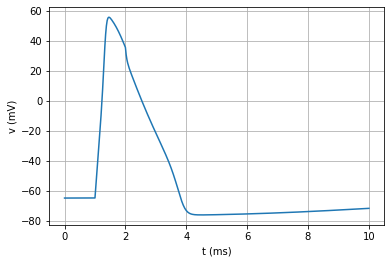

In [7]:
plt.plot(t, v)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
plt.grid()

Text(0, 0.5, 'activation / inactivation')

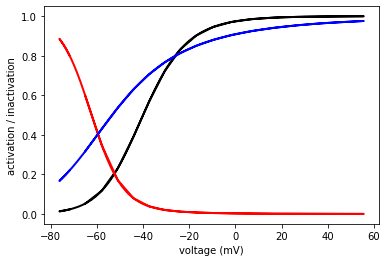

In [8]:
plt.plot(v, minf, 'k-', lw=2)
plt.plot(v, hinf, 'r-', lw=2)
plt.plot(v, ninf, 'b-', lw=2)
plt.xlabel('voltage (mV)')
plt.ylabel('activation / inactivation')

Text(0, 0.5, 'tau (ms)')

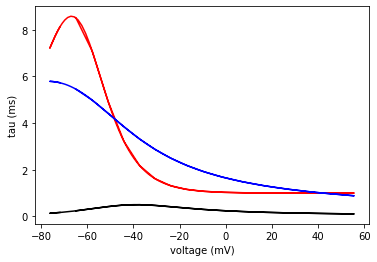

In [9]:
plt.plot(v,mtau,'k-')
plt.plot(v,htau,'r-')
plt.plot(v,ntau,'b-')
plt.xlabel('voltage (mV)')
plt.ylabel('tau (ms)')

In [10]:
v_cc = np.copy(v)
ninf_cc = np.copy(ninf)
ntau_cc = np.copy(ntau)
minf_cc = np.copy(minf)
mtau_cc = np.copy(mtau)
hinf_cc = np.copy(hinf)
htau_cc = np.copy(htau)

# Voltage clamp protocol

In [11]:
ena = 55
ek = -77

## Potassium current

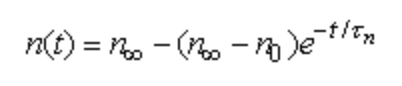

In [12]:
soma.gnabar_sodium = 0

We can simply the equation since $n_0=0$.
We get: 
$n(t)=n_\infty\cdot(1-\exp(-t/\tau_n))$

In [13]:
def func_exp_grow(x, A, tau):
    """Fit function."""
    return np.power(A * (1-np.exp(-x/tau)), 4)

In [14]:
# step current
vtest = -80
vclamp = h.VClamp(soma(0.5))
vclamp.dur[0] = 50
vclamp.amp[0] = -120
vclamp.dur[1] = 150
vclamp.amp[1] = vtest
vclamp.dur[2] = 50
vclamp.amp[2] = -120

In [15]:
# record voltage and time
v = h.Vector().record(soma(0.5)._ref_v)             # Membrane potential vector
t = h.Vector().record(h._ref_t)                     # Time stamp vector

# record current ... 
i_vc = h.Vector().record(soma(0.5)._ref_ik_potassium)

In [16]:
h.load_file('stdrun.hoc')
h.finitialize(-65)
tstop = 250
h.tstop = tstop
h.run()

0.0

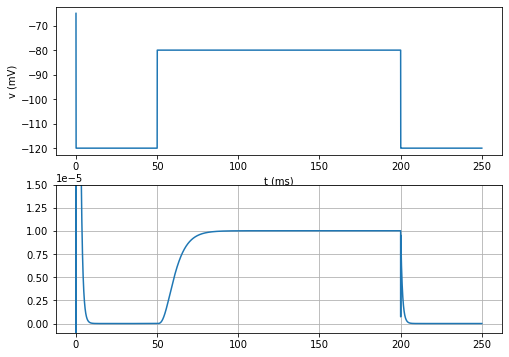

In [17]:
v_arr = np.array(v)
t_arr = np.array(t)
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(t_arr, v_arr)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
#plt.xlim(vclamp.dur[0]-5)
#
plt.subplot(212)
i_vc_display = np.array(i_vc)/(v_arr-ek)
plt.plot(t,i_vc_display)
#plt.xlim(vclamp.dur[0]-5)
plt.ylim(-1e-6, 1.5e-5)
plt.grid()

In [18]:
ik_peak = []
tauk_lst = []
vc_arr = np.arange(-100, 80, 10)
for vc in vc_arr:
    vclamp.amp[1] = vc
    h.run()
    t_arr = np.array(t)
    i_vc_arr = np.array(i_vc)    
    v_arr = np.array(v)
    
    idx_t = np.where((t_arr>vclamp.dur[0])&(t_arr<(vclamp.dur[0]+vclamp.dur[1]-10)))[0]
    
    g_t = i_vc_arr[idx_t] / (v_arr[idx_t]-ek)
    g_t[g_t<=0]=0
    g_t_pow = np.power(g_t, 0.25) 
    g_t_pow[np.isnan(g_t_pow)]=0
    
    # fit
    A0 = g_t_pow.max()
    """
    Aplat = 0.95*A0
    print(A0, Aplat)
    idx_plat = np.where(g_t_pow>Aplat)[0][0]
    t_arr[idx_t][idx_plat]/10
    """
    tau0 = 5 
    popt, _ = curve_fit(func_exp_grow, t_arr[idx_t]-vclamp.dur[0], g_t, p0=[A0, tau0], 
                        bounds=([1e-10, 1e-3], [10, 50]))

    for kk in range(10):
        popt, _ = curve_fit(func_exp_grow, t_arr[idx_t]-vclamp.dur[0], g_t, p0=popt, 
                            bounds=([1e-10, 1e-3], [10, 50]))
    
    
    tauk_lst.append(popt[1])
    plt.figure()
    plt.plot(t_arr[idx_t], g_t, marker='o', lw=0, markersize=2, label='vc=%g mV'%vc) 
    
    y_fit = func_exp_grow(t_arr[idx_t]-vclamp.dur[0], *popt)
    
    plt.plot(t_arr[idx_t], y_fit, 'r-')
    ik_peak.append(popt[0])

plt.legend(fontsize=6)

/home/tnieus/anaconda3/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)


/home/tnieus/anaconda3/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/tnieus/anaconda3/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/tnieus/anaconda3/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/tnieus/anaconda3/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_step) * np.sign(s).astype(int)
/home/tnieus/anaconda3/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:398: RuntimeWarning: invalid value encountered in cast
  return min_step, np.equal(steps, min_s

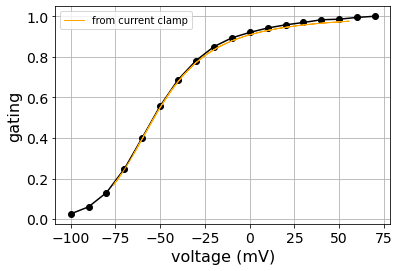

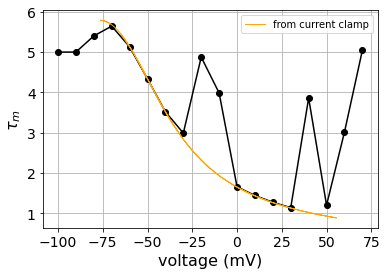

In [ ]:
ik_peak = np.array(ik_peak)
ik_peak = ik_peak/ik_peak.max()

# activation plot
plt.figure()
plt.plot(vc_arr, ik_peak, 'ko-')
plt.plot(v_cc, ninf_cc, color='orange', lw=1,  label='from current clamp')
plt.xlabel('voltage (mV)', fontsize=16)
plt.ylabel('gating', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid()

# tau plot
plt.figure()
plt.plot(vc_arr, tauk_lst, 'ko-')
plt.plot(v_cc, ntau_cc, color='orange', lw=1, label='from current clamp')
plt.xlabel('voltage (mV)', fontsize=16)
plt.ylabel(r'$\tau_m$', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend()
plt.grid()

## Sodium current

In [ ]:
i_vc_na = h.Vector().record(soma(0.5)._ref_ina_sodium)
soma.gnabar_sodium = 0.12

### activation

In [ ]:
vtest = -40
vclamp = h.VClamp(soma(0.5))
vclamp.dur[0] = 50
vclamp.amp[0] = -120
vclamp.dur[1] = 150
vclamp.amp[1] = vtest
vclamp.dur[2] = 50
vclamp.amp[2] = 120
h.tstop = vclamp.dur[0] + vclamp.dur[1] + vclamp.dur[2]

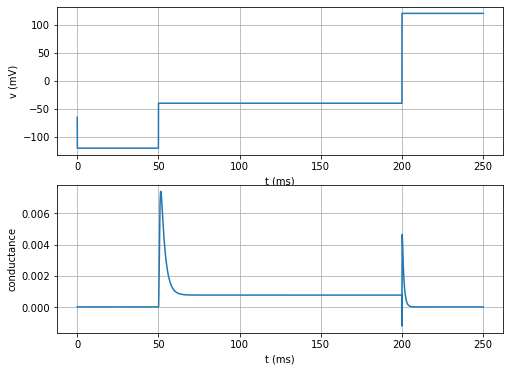

In [ ]:
h.run()
v_arr = np.array(v)
t_arr = np.array(t)
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(t_arr, v_arr)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)') 
plt.grid()
#
plt.subplot(212)
g_t = np.array(i_vc_na)/(v_arr-ena)
plt.plot(t, g_t)
plt.xlabel('t (ms)')
plt.ylabel('conductance') 
plt.grid()

In [ ]:
m_peak = []
tau_m = []
#tauk_lst = []
vc_arr = np.arange(-100, 80, 10)
for vc in vc_arr:
    vclamp.amp[1] = vc
    h.run()
    t_arr = np.array(t)
    i_vc_arr = np.array(i_vc_na)    
    v_arr = np.array(v)
    
    idx_t = np.where((t_arr>vclamp.dur[0])&(t_arr<(vclamp.dur[0]+vclamp.dur[1])))[0]
    
    g_t = i_vc_arr[idx_t] / (v_arr[idx_t]-ena)
    g_t[g_t<=0]=0
    g_t_pow = np.power(g_t, 1/3) 
    g_t_pow[np.isnan(g_t_pow)]=0
    
    # record
    m_peak.append(g_t_pow.max())
    idx_max = np.argmax(g_t)
    tau_m.append(t_arr[idx_t][idx_max]-t_arr[idx_t][0])

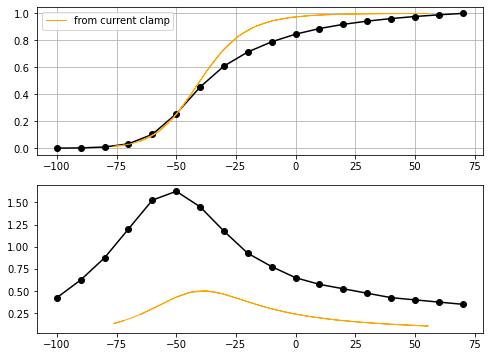

In [ ]:
# activation plot
m_peak = np.array(m_peak)
m_peak /= m_peak.max()
plt.figure(figsize=(8,6))
plt.subplot(211)
plt.plot(vc_arr, m_peak, 'ko-')
plt.plot(v_cc, minf_cc, color='orange', lw=1,  label='from current clamp')
plt.legend()
plt.grid()
plt.subplot(212)
plt.plot(vc_arr, tau_m, 'ko-')
plt.plot(v_cc, mtau_cc, color='orange', lw=1,  label='from current clamp')


### inactivation


We get: 
$h(t)=h_\infty - (h_\infty-h_0)\cdot \exp(-t/\tau_h)$

In [ ]:
def func_inact(x, A, tau):
    """Fit function."""
    return A * np.exp(-x/tau)

In [ ]:
vtest = -40
vclamp.dur[0] = 50
vclamp.amp[0] = -120
vclamp.dur[1] = 150
vclamp.amp[1] = vtest
vclamp.dur[2] = 25
vclamp.amp[2] = 80
h.tstop = vclamp.dur[0] + vclamp.dur[1] + vclamp.dur[2]

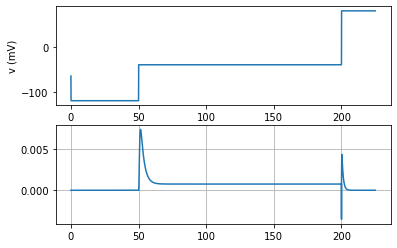

In [ ]:
h.run()
v_arr = np.array(v)
t_arr = np.array(t)
plt.subplot(211)
plt.plot(t_arr, v_arr)
plt.xlabel('t (ms)')
plt.ylabel('v (mV)')
#
plt.subplot(212)
i_vc_display = np.array(i_vc_na)/(v_arr-ena)
plt.plot(t, i_vc_display)
plt.grid()

#### $h_\infty$

In [ ]:
vc_arr = np.arange(-100, 20, 10)

tb = vclamp.dur[0]+vclamp.dur[1]
te = tstop

gna_peak = []
t_peak = []
tau_na_lst = []

for vc in vc_arr:
    vclamp.amp[1] = vc
    h.run()
    t_arr = np.array(t)
    i_vc_arr = np.array(i_vc_na)    
    v_arr = np.array(v)
    idx_t = np.where((t_arr>tb)&(t_arr<te))[0]
    #
    time = t_arr[idx_t]-tb 
    g_t = i_vc_arr[idx_t] / (v_arr[idx_t]-ena)    
    idx_peak = np.argmax(g_t)
    t_peak.append(time[idx_peak])
    gna_peak.append(g_t[idx_peak])

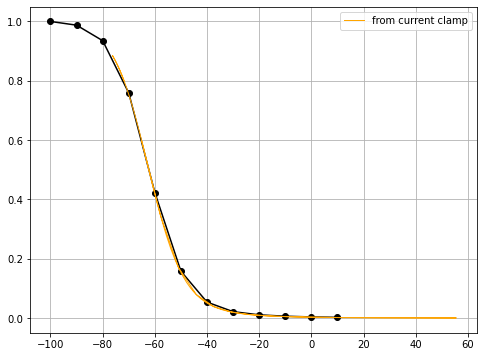

In [ ]:
plt.figure(figsize=(8,6))    
gna_peak = np.array(gna_peak)
gna_peak /= gna_peak.max()
plt.plot(vc_arr, gna_peak, 'ko-')    
plt.plot(v_cc, hinf_cc, color='orange', lw=1,  label='from current clamp')
plt.legend()
plt.grid()

#### $\tau_h$

TO DO (requires ad-hoc PROTOCOL)

In [ ]:
dur_test = 100
vclamp = h.VClamp(soma(0.5))
vclamp.dur[0] = 50
vclamp.amp[0] = 120
vclamp.dur[1] = dur_test
vclamp.amp[1] = -120
vclamp.dur[2] = 20
vclamp.amp[2] = 120
h.tstop = vclamp.dur[0] + vclamp.dur[1] + vclamp.dur[2]
print(h.tstop)

170.0


0.1 5.599237576262057e-08
2.1 5.808304853228593e-08
4.1 6.123952720123498e-08
6.1 6.17863822499323e-08
8.1 6.184759151603863e-08
10.1 6.185446515973412e-08
12.1 6.185523434595239e-08
14.1 6.185532042030151e-08
16.1 6.185533005214671e-08
18.1 6.185533112991016e-08
20.1 6.185533125048441e-08
22.1 6.185533126396287e-08
24.1 6.185533126546417e-08
26.1 6.18553312656284e-08
28.1 6.18553312656446e-08


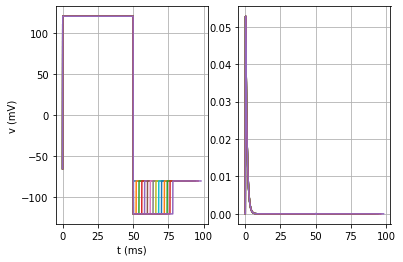

In [ ]:
vclamp.amp[2] = -80
for dur_test in np.arange(0.1,30,2):
    vclamp.dur[1] = dur_test
    h.tstop = vclamp.dur[0] + vclamp.dur[1] + vclamp.dur[2]
    h.run()
    v_arr = np.array(v)
    t_arr = np.array(t)
    plt.subplot(121)
    plt.plot(t_arr, v_arr)
    plt.xlabel('t (ms)')
    plt.ylabel('v (mV)')
    plt.grid()
    #
    plt.subplot(122)
    i_vc_display = np.array(i_vc_na)/(v_arr-ena)
    plt.plot(t, i_vc_display)
    plt.grid()
    
    tb = vclamp.dur[0]+vclamp.dur[1]
    te = tstop
    idx_t = np.where((t_arr>tb)&(t_arr<te))[0]
    print(dur_test, i_vc_display[idx_t].max())